In [1]:
import sys
print(sys.executable)


c:\Users\samue\AppData\Local\Programs\Python\Python39\python.exe


In [2]:
import tensorboard
print(tensorboard.__version__)
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


2.19.0


In [3]:
import pandas as pd
import os

# 1. Učitaj metapodatke
df = pd.read_csv('dataset/HAM10000_metadata.csv')

# 2. Definiraj gdje tražimo slike
image_folders = ['dataset/HAM10000_images_part_1', 'dataset/HAM10000_images_part_2']

def find_image_path(image_id):
    for folder in image_folders:
        path = os.path.join(folder, f'{image_id}.jpg')
        if os.path.exists(path):
            return path
    return None  # Ako ne postoji

# 3. Dodaj stupac s punim putanjama do slika
df['path'] = df['image_id'].apply(find_image_path)

# 4. Kodiranje labela (dijagnoza)
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# 5. Provjera ima li slika koje nisu pronađene
print("Nedostajuće slike:", df['path'].isnull().sum())


Nedostajuće slike: 0


In [4]:
from sklearn.model_selection import train_test_split

# Prvo odvojimo 80% za trening, a 20% za (validacija + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Sada 20% podijelimo po pola (10% validacija, 10% test)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)


In [5]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        label = self.dataframe.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 📐 Veličina slike
image_size = 224

# 🧠 Točna normalizacija za ResNet50 treniran na ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# 🔁 Transformacije za treniranje (s augmentacijom)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# 🔍 Transformacije za validaciju i test (bez augmentacije)
eval_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# 📦 Dataseti
train_dataset = SkinLesionDataset(train_df, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, transform=eval_transforms)
test_dataset = SkinLesionDataset(test_df, transform=eval_transforms)

# 🚚 DataLoaderi
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='runs/skin_diagnosis_experiment2')


In [8]:
import torch

if torch.cuda.is_available():
    print("✅ GPU aktivan:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU NIJE aktivan – koristiš CPU.")


✅ GPU aktivan: NVIDIA GeForce RTX 4060 Ti


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Učitaj pretrenirani EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Ukloni originalni klasifikacijski sloj i zamijeni vlastitim
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 7)  # 7 klasa za HAM10000
)

# Premjesti na GPU/CPU
model = model.to(device)


c:\Users\samue\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samue\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\samue/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 17.1MB/s]


In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Izračunaj težine
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

# Pretvori u tensor i prebaci na GPU (ako treba)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Dodaj u loss funkciju
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [11]:
from tqdm import tqdm

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')

    return total_loss / len(dataloader.dataset), acc, f1, recall, precision


In [12]:
print("Ukupno slika:", len(df))
print("Trening skup:", len(train_df))
print("Validacijski skup:", len(val_df))
print("Testni skup:", len(test_df))
print("\nDistribucija klasa (trening):")
print(train_df['label'].value_counts())
print("\nDistribucija klasa (validacija):")
print(val_df['label'].value_counts())


Ukupno slika: 10015
Trening skup: 8012
Validacijski skup: 1001
Testni skup: 1002

Distribucija klasa (trening):
label
1    5364
3     890
0     879
5     411
6     262
4     114
2      92
Name: count, dtype: int64

Distribucija klasa (validacija):
label
1    670
3    111
0    110
5     51
6     33
4     14
2     12
Name: count, dtype: int64


In [18]:
best_f1 = 0.0
patience = 3
counter = 0

for epoch in range(10):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/10'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_precision = precision_score(all_labels, all_preds, average='macro')

    val_loss, val_acc, val_f1, val_recall, val_precision = evaluate_model(model, val_loader)

    # TensorBoard logging
    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalars('F1', {'Train': train_f1, 'Val': val_f1}, epoch)
    writer.add_scalars('Recall', {'Train': train_recall, 'Val': val_recall}, epoch)
    writer.add_scalars('Precision', {'Train': train_precision, 'Val': val_precision}, epoch)

    print(f"📊 Epoch {epoch+1}/10")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), 'best_efficient_net.pth')
        print("✅ Saved new best model")
    else:
        counter += 1
        print(f"⚠️ No improvement in F1 for {counter} epoch(s)")
        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break
##$$ OVO JE JOS BOLJEŠANO S OBZIROM DA JE DODAN EARLY STOPPING

Epoch 1/10: 100%|██████████| 251/251 [01:07<00:00,  3.73it/s]


📊 Epoch 1/10
Train Loss: 0.2810 | Val Loss: 0.7420
Train Acc: 0.8542 | Val Acc: 0.8062
Train F1: 0.8359 | Val F1: 0.7558
✅ Saved new best model


Epoch 2/10: 100%|██████████| 251/251 [01:10<00:00,  3.55it/s]


📊 Epoch 2/10
Train Loss: 0.2375 | Val Loss: 0.5844
Train Acc: 0.8677 | Val Acc: 0.7992
Train F1: 0.8543 | Val F1: 0.7500
⚠️ No improvement in F1 for 1 epoch(s)


Epoch 3/10: 100%|██████████| 251/251 [01:12<00:00,  3.47it/s]


📊 Epoch 3/10
Train Loss: 0.2304 | Val Loss: 0.5866
Train Acc: 0.8747 | Val Acc: 0.8352
Train F1: 0.8535 | Val F1: 0.7787
✅ Saved new best model


Epoch 4/10: 100%|██████████| 251/251 [01:13<00:00,  3.43it/s]


📊 Epoch 4/10
Train Loss: 0.1907 | Val Loss: 0.5771
Train Acc: 0.8839 | Val Acc: 0.8382
Train F1: 0.8731 | Val F1: 0.7803
✅ Saved new best model


Epoch 5/10: 100%|██████████| 251/251 [01:11<00:00,  3.52it/s]


📊 Epoch 5/10
Train Loss: 0.1784 | Val Loss: 0.6950
Train Acc: 0.8940 | Val Acc: 0.8442
Train F1: 0.8810 | Val F1: 0.7853
✅ Saved new best model


Epoch 6/10: 100%|██████████| 251/251 [01:11<00:00,  3.49it/s]


📊 Epoch 6/10
Train Loss: 0.1656 | Val Loss: 0.6192
Train Acc: 0.8972 | Val Acc: 0.8442
Train F1: 0.8861 | Val F1: 0.7954
✅ Saved new best model


Epoch 7/10: 100%|██████████| 251/251 [01:10<00:00,  3.55it/s]


📊 Epoch 7/10
Train Loss: 0.1454 | Val Loss: 0.6278
Train Acc: 0.9091 | Val Acc: 0.8322
Train F1: 0.9051 | Val F1: 0.7832
⚠️ No improvement in F1 for 1 epoch(s)


Epoch 8/10: 100%|██████████| 251/251 [01:14<00:00,  3.38it/s]


📊 Epoch 8/10
Train Loss: 0.1565 | Val Loss: 0.6051
Train Acc: 0.9073 | Val Acc: 0.8571
Train F1: 0.8881 | Val F1: 0.8152
✅ Saved new best model


Epoch 9/10: 100%|██████████| 251/251 [01:12<00:00,  3.45it/s]


📊 Epoch 9/10
Train Loss: 0.1247 | Val Loss: 0.5891
Train Acc: 0.9156 | Val Acc: 0.8521
Train F1: 0.9140 | Val F1: 0.8062
⚠️ No improvement in F1 for 1 epoch(s)


Epoch 10/10: 100%|██████████| 251/251 [01:14<00:00,  3.38it/s]


📊 Epoch 10/10
Train Loss: 0.1177 | Val Loss: 0.6737
Train Acc: 0.9219 | Val Acc: 0.8731
Train F1: 0.9075 | Val F1: 0.7960
⚠️ No improvement in F1 for 2 epoch(s)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs


In [25]:
model.load_state_dict(torch.load("best_efficient_net.pth"))
model.eval()
test_loss, test_acc, test_f1, test_recall, test_precision = evaluate_model(model, test_loader)
print(f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")


C:\Users\samue\AppData\Local\Temp\ipykernel_2236\1460284974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_efficient_net.pth"))


Test Acc: 0.8533 | Test F1: 0.7435


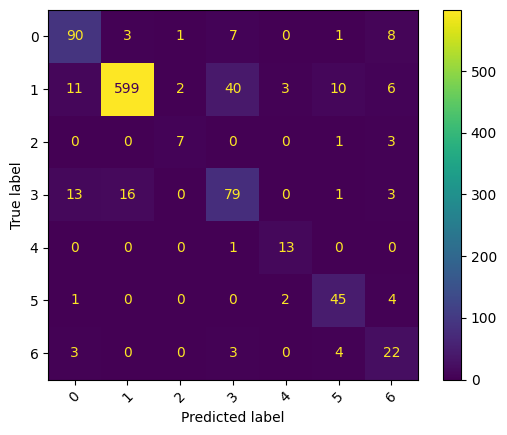

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)


In [21]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=df['dx'].unique()))


              precision    recall  f1-score   support

         bkl       0.76      0.82      0.79       110
          nv       0.97      0.89      0.93       671
          df       0.70      0.64      0.67        11
         mel       0.61      0.71      0.65       112
        vasc       0.72      0.93      0.81        14
         bcc       0.73      0.87      0.79        52
       akiec       0.48      0.69      0.56        32

    accuracy                           0.85      1002
   macro avg       0.71      0.79      0.74      1002
weighted avg       0.87      0.85      0.86      1002

